# Generative Adversarial Networks

For this part of the assignment you implement two different types of generative adversarial networks. We will train the networks on the Celeb A dataset which is a large set of celebrity face images.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from torch.autograd import Variable
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
!rm -rf gan


In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
NOISE_DIM = 100
batch_size = 128
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
!wget https://uofi.box.com/shared/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip

--2019-05-05 04:09:23--  https://uofi.box.com/shared/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
Resolving uofi.box.com (uofi.box.com)... 107.152.26.197
Connecting to uofi.box.com (uofi.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip [following]
--2019-05-05 04:09:23--  https://uofi.box.com/public/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip [following]
--2019-05-05 04:09:23--  https://uofi.app.box.com/public/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
Resolving uofi.app.box.com (uofi.app.box.com)... 107.152.24.199, 107.152.25.199
Connecting to uofi.app.box.com (uofi.app.box.com)|107.152.24.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http

In [0]:
! mkdir celeba_data
! unzip q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip -d celeba_data
! rm q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip

In [50]:
!unzip gan.zip

Archive:  gan.zip
   creating: gan/
  inflating: gan/losses.py           
  inflating: gan/models.py           
  inflating: gan/train.py            
  inflating: gan/utils.py            


In [1]:
from gan.train import train

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
!ls

 celeba_data   gan  'gan (1).zip'   gan.zip   sample_data


In [30]:
!unzip gan.zip

Archive:  gan.zip
replace gan/losses.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gan/losses.py           
replace gan/models.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gan/models.py           
replace gan/train.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gan/train.py            
replace gan/utils.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gan/utils.py            


# GAN loss functions

In this assignment you will implement two different types of GAN cost functions. You will first implement the loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). You will also implement the loss from [LS-GAN](https://arxiv.org/abs/1611.04076). 

### GAN loss

**TODO:** Implement the `discriminator_loss` and `generator_loss` functions in `gan/losses.py`.

The generator loss is given by:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [6]:
from gan.losses import discriminator_loss, generator_loss

### Least Squares GAN loss

**TODO:** Implement the `ls_discriminator_loss` and `ls_generator_loss` functions in `gan/losses.py`.

We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [7]:
from gan.losses import ls_discriminator_loss, ls_generator_loss

# GAN model architecture

**TODO:** Implement the `Discriminator` and `Generator` networks in `gan/models.py`.

We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):

**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1

Instead of Relu we LeakyReLu throughout the discriminator (we use a negative slope value of 0.2). 

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





In [8]:
from gan.models import Discriminator, Generator

# Data loading: Celeb A Dataset

The CelebA images we provide have been filtered to obtain only images with clear faces and have been cropped and downsampled to 128x128 resolution.

In [12]:
batch_size = 128
scale_size = 64  # We resize the images to 64x64 for training

celeba_root = 'celeba'

In [13]:
celeba_train = ImageFolder(root=celeba_root, transform=transforms.Compose([
  transforms.Resize(scale_size),
  transforms.ToTensor(),
]))

celeba_loader_train = DataLoader(celeba_train, batch_size=batch_size, drop_last=True)

### Visualize dataset

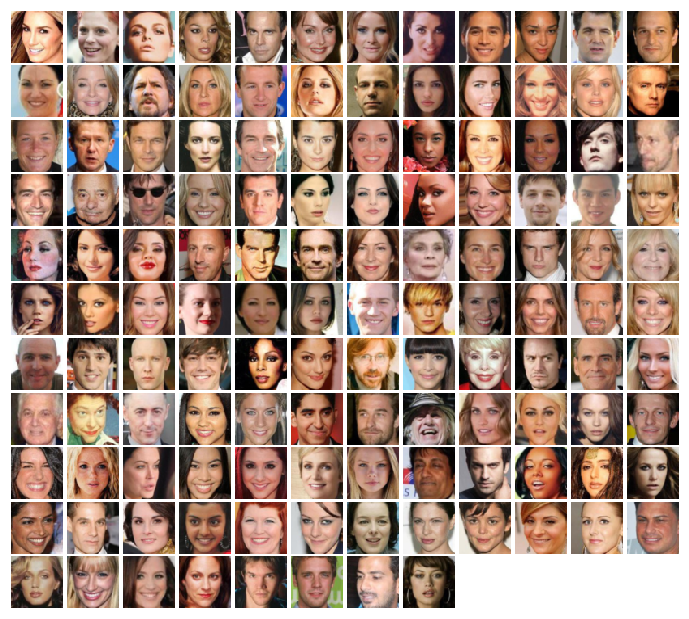

In [17]:
imgs = celeba_loader_train.__iter__().next()[0].numpy().squeeze()
show_images(imgs, color=True)

In [31]:
from gan.utils import show_images,preprocess_img

In [32]:
from gan.utils import sample_noise

In [33]:
import torchvision.utils as vutils

In [ ]:
def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None):
    """
    Train loop for GAN.
    
    The loop will consist of two steps: a discriminator step and a generator step.
    
    (1) In the discriminator step, you should zero gradients in the discriminator 
    and sample noise to generate a fake data batch using the generator. Calculate 
    the discriminator output for real and fake data, and use the output to compute
    discriminator loss. Call backward() on the loss output and take an optimizer
    step for the discriminator.
    
    (2) For the generator step, you should once again zero gradients in the generator
    and sample noise to generate a fake data batch. Get the discriminator output
    for the fake data batch and use this to compute the generator loss. Once again
    call backward() on the loss and take an optimizer step.
    
    You will need to reshape the fake image tensor outputted by the generator to 
    be dimensions (batch_size x input_channels x img_size x img_size).
    
    Use the sample_noise function to sample random noise, and the discriminator_loss
    and generator_loss functions for their respective loss computations.
    
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - train_loader: image dataloader
    - device: PyTorch device
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_loader:
             
            
            D_solver.zero_grad()
            real_images = preprocess_img(x).to(device)
            
             
            logits_real = D(real_images)
      
            g_fake_seed = Variable(sample_noise(batch_size, noise_size))
            g_fake_seed=g_fake_seed.to(device)
            fake_images = G(g_fake_seed).detach()
            
            logits_fake = D(fake_images.view(batch_size, 3, 64, 64))
            
            d_total_error = discriminator_loss(logits_real, logits_fake).mean()
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size))
            g_fake_seed=g_fake_seed.to(device)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 3, 64, 64))
            g_error = generator_loss(gen_logits_fake).mean()
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                
                show_images(imgs_numpy[0:16],color=True)
               # vutils.save_image(fake_images.data, '%sfake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)
                plt.show()
                print()
            iter_count += 1

In [25]:
??train

# Training 


**TODO:** Fill in the training loop in `gan/train.py`.

In [ ]:
NOISE_DIM = 100
NUM_EPOCHS = 50
learning_rate = 0.0002

### Train GAN

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [ ]:
# original gan
train(D, G, D_optimizer, G_optimizer, discriminator_loss, 
          generator_loss, num_epochs=NUM_EPOCHS, show_every=250,
          train_loader=celeba_loader_train, device=device)


### Train LS-GAN

In [0]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [0]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [0]:
# ls-gan
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, 
          ls_generator_loss, num_epochs=NUM_EPOCHS, show_every=200,
          train_loader=celeba_loader_train, device=device)